In [2]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage.feature import canny
from collections import defaultdict
from PIL import Image
from skimage.color import rgba2rgb, rgb2gray
from skimage.feature import local_binary_pattern
from itertools import combinations
from shapely.geometry import box
from shapely.geometry.polygon import Polygon

matplotlib.rcParams['font.family'] = 'Times New Roman'

In [3]:
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()

## Cantidad de fotos por set

In [4]:
directorio = './images'

In [5]:
cantidad_fotos = 0


for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        cantidad_fotos += 1


print(f"La carpeta '{directorio}' contiene {cantidad_fotos} fotos.")

La carpeta './images' contiene 2000 fotos.


In [6]:
fotos_por_set = defaultdict(int)

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        numero_set = filename.split('_')[0]
        fotos_por_set[numero_set] += 1



In [7]:
df = pd.read_csv('layoutsWithTags.csv')
numeros_de_sets_csv = df['layout_id'].unique()

def verificar_coincidencia(numero_set_csv):
    return str(numero_set_csv) in fotos_por_set

df['coincidencia'] = df['layout_id'].apply(verificar_coincidencia)
df_coincidentes = df[df['coincidencia']]

df_coincidentes.to_csv('layoutsWithTags.csv', index=False)

print(f"Se han guardado {len(df_coincidentes)} casos coincidentes en 'layoutsWithTags_coincidentes.csv'.")

Se han guardado 113 casos coincidentes en 'layoutsWithTags_coincidentes.csv'.


C:\Users\nicky\AppData\Local\Temp\ipykernel_21720\3919347955.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


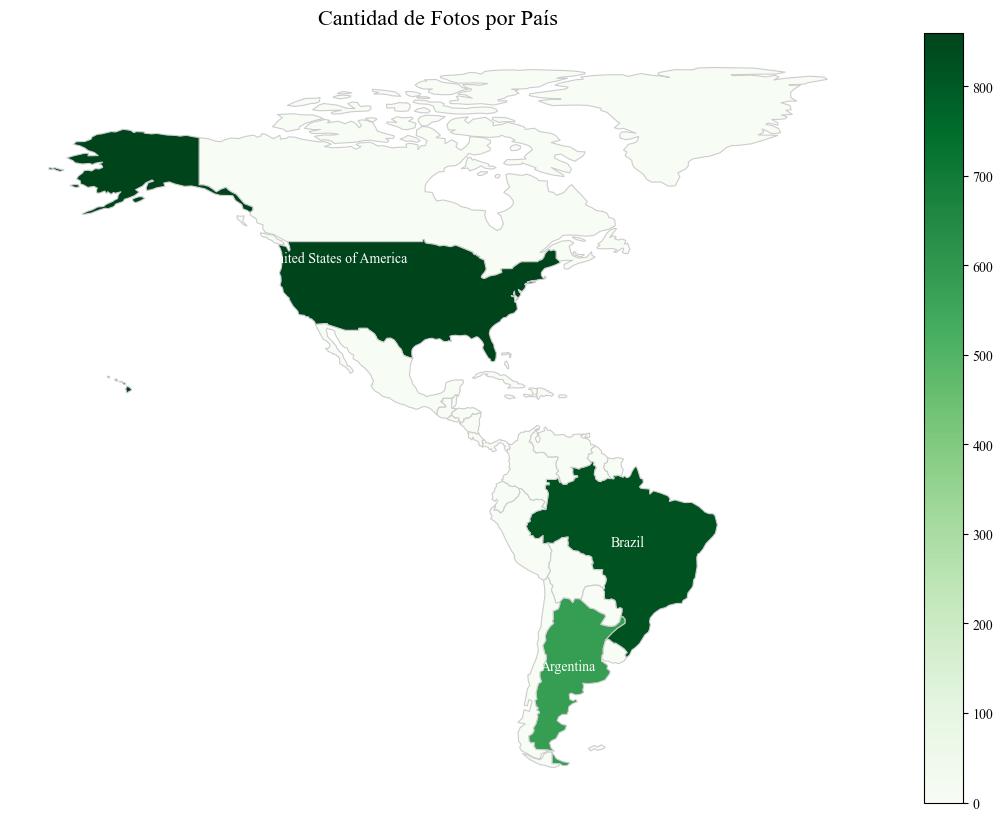

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


df = pd.read_csv('layoutsWithTags.csv')


df['country'] = df['country'].replace({'USA': 'United States of America'})


conteo_paises = df['country'].value_counts() * 20  # Multiplicar por 20

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world_americas = world[(world['continent'] == 'North America') | (world['continent'] == 'South America')]

world_americas = world_americas.merge(conteo_paises, how='left', left_on='name', right_index=True)

world_americas[conteo_paises.name] = world_americas[conteo_paises.name].fillna(0)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))


world_americas.plot(column=conteo_paises.name, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)


for idx, row in world_americas.iterrows():
    if row[conteo_paises.name] > 0:
        plt.annotate(text=row['name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), 
                     horizontalalignment='center', verticalalignment='center', fontsize=10, color='white', fontname='Times New Roman')

plt.title('Cantidad de Fotos por País', fontsize=16)

plt.axis('off')
plt.show()


## Etiquetas

In [9]:
sin_etiquetas = df['relevant (new) tags'].isnull().sum()
fotos_sin_etiquetas = sin_etiquetas * 20

print(f"Total de filas sin etiquetas: {sin_etiquetas}")
print(f"Total de fotos sin etiquetas: {fotos_sin_etiquetas}")

Total de filas sin etiquetas: 13
Total de fotos sin etiquetas: 260


# Análisis grupos tamaño 
### Este código tardad bastante (3min) en correr

In [10]:
import os
from PIL import Image, ImageStat
import pandas as pd


filas = []


for index, row in df.iterrows():
    layout_id = row['layout_id']
    country = row['country']
    relevant = row['relevant (new) tags']
    coincidencia = row['coincidencia']
    # Filtro las fotos de ese layout
    imagenes_layout = [filename for filename in os.listdir(directorio) if filename.startswith(str(layout_id) + '_')]
    # Iterar por todas las fotos
    for filename in imagenes_layout:
        # Extraigo características
        img = Image.open(os.path.join(directorio, filename))
        ancho, alto = img.size
        brillo = img.getextrema()[0][0]
        tonalidad = img.getextrema()[1][0]

        # Saturación
        s, _, _ = img.convert('HSV').split()
        estadisticas_saturacion = ImageStat.Stat(s)
        saturacion = estadisticas_saturacion.mean[0]

        # Agrego datos
        filas.append({
            'trial_id': row['trial_id'],
            'layout_id': layout_id,
            'country': country,
            'relevant (new) tags': relevant,
            'coincidencia': coincidencia,
            'nombre_imagen': filename,
            'ancho': ancho,
            'alto': alto,
            'brillo': brillo,
            'tonalidad': tonalidad,
            'saturacion': saturacion,
        })

# Convertir la lista de diccionarios en un DataFrame
nuevo_df = pd.DataFrame(filas)


In [11]:
nuevo_df.to_csv('./layouts_fotos', index=False)


In [12]:
# Cambio alto a largo

print(nuevo_df.head())
print(nuevo_df.columns)




   trial_id  layout_id country relevant (new) tags  coincidencia  \
0    9446.0      53750  Brazil           2,4,5,6,8          True   
1    9446.0      53750  Brazil           2,4,5,6,8          True   
2    9446.0      53750  Brazil           2,4,5,6,8          True   
3    9446.0      53750  Brazil           2,4,5,6,8          True   
4    9446.0      53750  Brazil           2,4,5,6,8          True   

        nombre_imagen  ancho  alto  brillo  tonalidad  saturacion  
0  53750_1-1-10-4.png    927    90       0          0   29.292389  
1  53750_1-10-6-6.png    931    90       0          0   49.217222  
2  53750_1-10-7-7.png    931    90       0          0   48.946294  
3  53750_1-12-1-8.png    933    90       0          0   37.098261  
4  53750_1-18-2-7.png    936    90       0          0   30.093863  
Index(['trial_id', 'layout_id', 'country', 'relevant (new) tags',
       'coincidencia', 'nombre_imagen', 'ancho', 'alto', 'brillo', 'tonalidad',
       'saturacion'],
      dtype='ob

C:\Users\nicky\AppData\Local\Temp\ipykernel_21720\2047526260.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y='ancho', data=nuevo_df, ax=axes[0], palette=palette)
C:\Users\nicky\AppData\Local\Temp\ipykernel_21720\2047526260.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y='alto', data=nuevo_df, ax=axes[1], palette=palette)


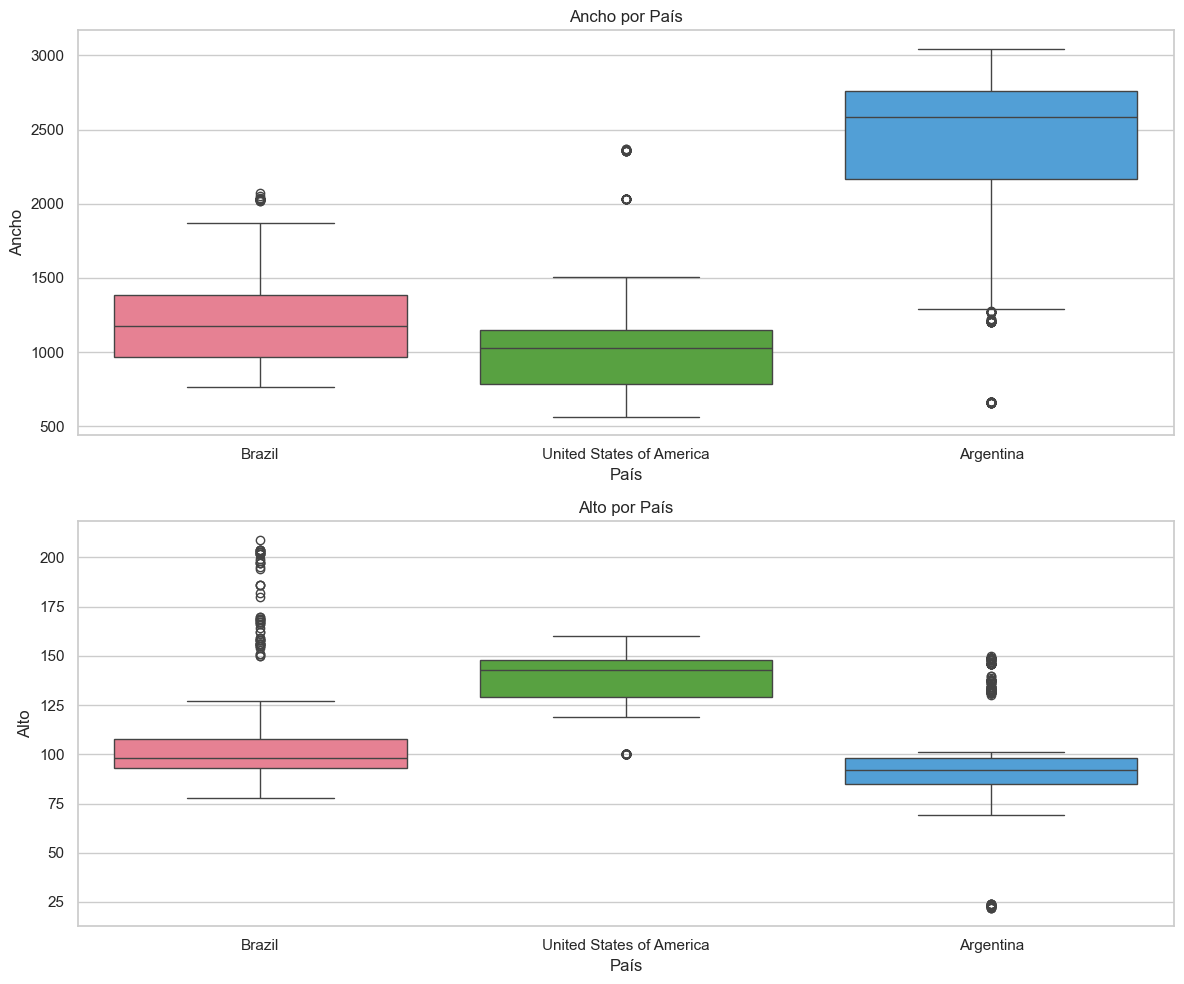

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

#Diagrama de caja y bigotes
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Para el ancho por país
sns.boxplot(x='country', y='ancho', data=nuevo_df, ax=axes[0])
axes[0].set_title('Ancho por País')
axes[0].set_xlabel('País')
axes[0].set_ylabel('Ancho')

# Para el Alto por país
sns.boxplot(x='country', y='alto', data=nuevo_df, ax=axes[1])
axes[1].set_title('Alto por País')
axes[1].set_xlabel('País')
axes[1].set_ylabel('alto')


plt.tight_layout()
plt.show()


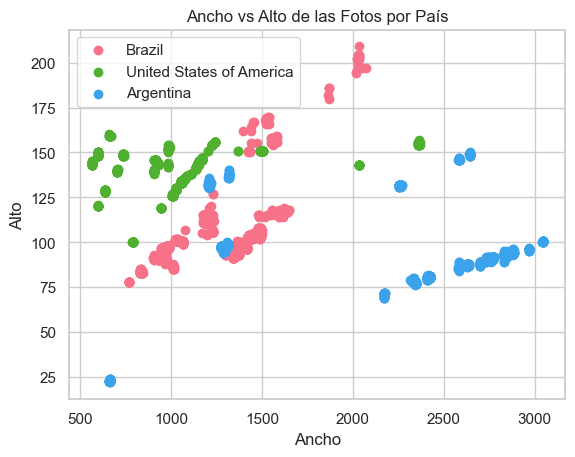

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

#Scatter plot
palette = sns.color_palette("husl", len(nuevo_df['country'].unique()))
fig, ax = plt.subplots()

for country, color in zip(nuevo_df['country'].unique(), palette):
    df_country = nuevo_df[nuevo_df['country'] == country]
    ax.scatter(df_country['ancho'], df_country['alto'], label=country, color=color)

# Etiquetas y título
ax.set_xlabel('Ancho')
ax.set_ylabel('Alto')
ax.set_title('Ancho vs Alto de las Fotos por País')
ax.legend()

plt.show()


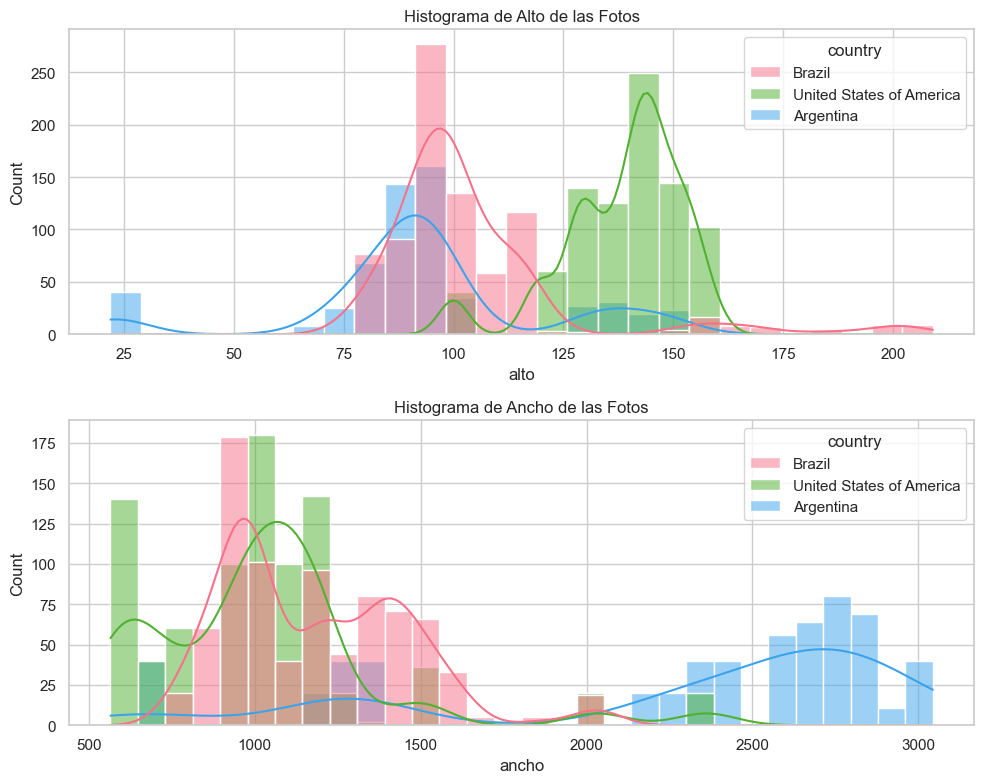

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo
sns.set(style="whitegrid")


fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Histograma de alto de las fotos,  por país
sns.histplot(data=nuevo_df, x='alto', hue='country', ax=axes[0], kde=True, palette= palette)
axes[0].set_title('Histograma de Alto de las Fotos')

# Histograma de Ancho de las fotos,  por país
sns.histplot(data=nuevo_df, x='ancho', hue='country', ax=axes[1], kde=True, palette= palette)
axes[1].set_title('Histograma de Ancho de las Fotos')

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()
